In [1]:
import numpy as np 
import pandas as pd
from pandas import datetime
from datetime import datetime
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline    

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as MSE
from tabulate import tabulate



import warnings
warnings.filterwarnings("ignore")#忽略警告提醒


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
#from statsmodels.tsa.stattools import acf
#random_walk_acf = acf(df)
#acf_plot = plot_acf(random_walk_acf, lags=20)

Step1:
先圖示化資料的樣貌，並且繪製出資料的自相關與偏自相關圖，從自相關的圖可以看到自相關的情形相當明顯，除此之外也利用單跟檢定，利用ADF檢定單跟的方式，檢定結果發現pvalue高達0.85，大於顯著水準，不拒絕虛無假設，圖視覺化相關係數與單跟檢定結果可以知道此資料為非定態。

p-value: 0.9983


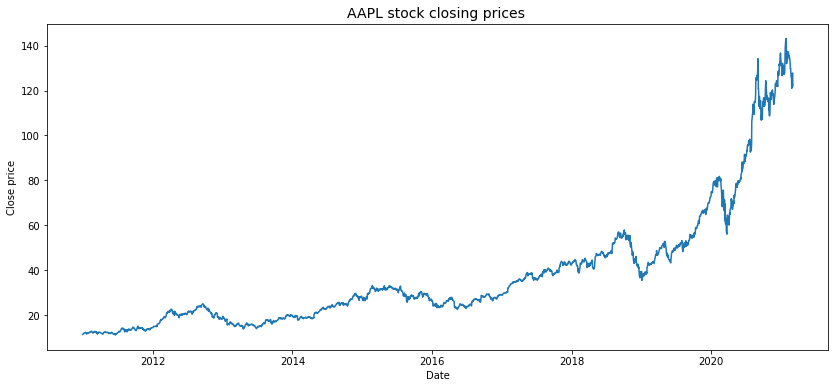

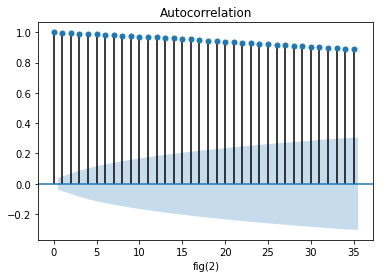

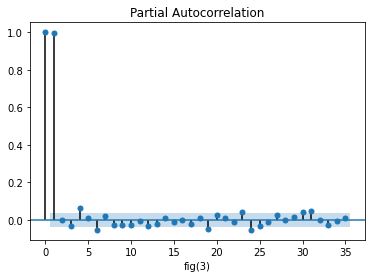

In [3]:
def read_data( ) :
    df = DataReader('AAPL', data_source='yahoo', start='2011-01-01', end=datetime.now()).drop(
    ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)#從雅虎finance抓取資料
    df.head()
    df.index = pd.to_datetime(df.index)
    plt.figure(figsize = (14,6)) 
    plt.title('AAPL stock closing prices ', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.plot(df['Close'] )


    plot_acf(df)
    plt.xlabel('fig(2)')
    
    plot_pacf(df)
    plt.xlabel('fig(3)')
    
    result = adfuller(df['Close'])
    print('p-value: {}'.format(round(result[1],4)))
    return df
df = read_data()

Step2:
此非定態資料利用一階差分的方式將資料轉為定態，並繪製其自相關係數與偏自相關係數圖，再利用ADF檢定單跟是否存在，可得到pvalue小於0.05，且非常接近零，拒絕虛無假設，解決了單跟的問題。

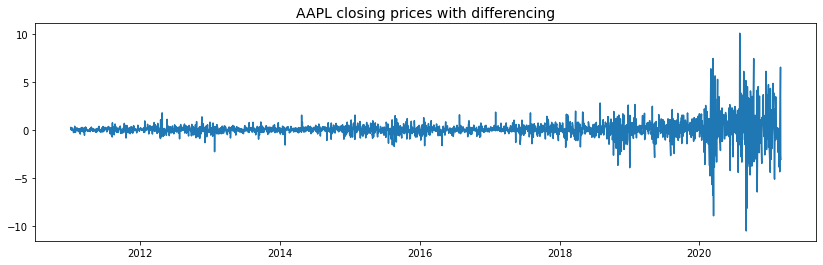

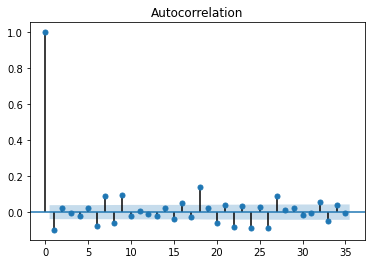

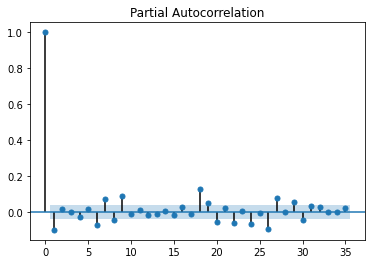

p-value: 0.000000


In [4]:
def test_stational(df):
    
    df_diff = df.diff(periods=1).dropna()# 為了使數據平整，進行一階插方調整，並且進行檢定
#    adf_data = ADF(df_diff)
    plt.figure(figsize = (14,4))
    plt.title("AAPL closing prices with differencing",fontsize=14)
    plt.plot(df_diff)
    
    plot_acf(df_diff)
    plot_pacf(df_diff)
    plt.show()
    
    result = adfuller(df_diff['Close'])
    print('p-value: %f' % result[1])
    return df
df_diff = test_stational(df)

Step3:
由資料型態可以推論出此為ARIMA(1,1,1）模型，但為了盡可能使AIC最小，所以設迴圈來計算當p與q為何時AIC最小，ｐ的範圍設定為1-3，q的範圍設定為1-3，得出結果(p,q)=(1,1)得出ARIMA參數。

In [5]:
Order = []
for p in range(1,3):
    for q in range(1,3):
        try:
            model = ARIMA(df_diff, order=(p, 1, q))
            results = model.fit(disp=0)
            Order.append(round(pd.read_html(results.summary().as_html(), header=0, index_col=0)[0].iloc[2,2],2))
        except:
            Order.append('NA')
            print('No Result')

b = [Order[i:i+2] for i in range(0,len(Order),2)]
Order_df = pd.DataFrame(b,index=range(1,3),columns=range(1,3))
Order_df.index.name = "p \\ q "
print(tabulate(Order_df, headers='keys', tablefmt='fancy_grid',numalign="center"))


╒══════════╤═════════╤═════════╕
│  p \ q   │    1    │    2    │
╞══════════╪═════════╪═════════╡
│    1     │ 7292.01 │ 7293.93 │
├──────────┼─────────┼─────────┤
│    2     │ 7293.95 │ 7214.22 │
╘══════════╧═════════╧═════════╛


Step4:首先來看看配適模型後的統計結果，先將資料的80%最為訓練集、20%作為測試集。而當我們預測完一天後，將會把當天實際真實的股價加進訓練資料，再進行隔一天的預測作，如此不斷重複。

In [6]:
price = df_diff.values
length = int(len(price) * 0.8)
train = list(price[0:length])
test =  price[length:len(price)]
df_diff = df_diff.index[length:len(price)]
predictions = []

for i in range(len(test)):
    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit(disp=0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    real = test[i]
    train.append(real[0])   
#如果要製作上下界：    low_bound.append(model_fit.forecast()[2][0][0])
#    up_bound.append(model_fit.forecast()[2][0][1])

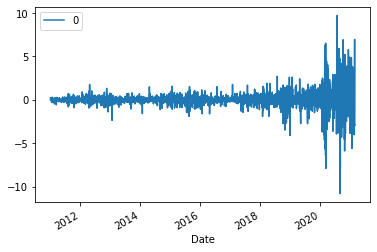

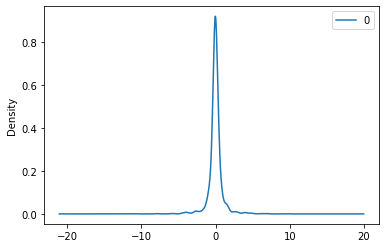

In [7]:
#觀察殘差機率分佈圖，發現殘差有符合平穩，且符合正態分佈
residuals = pd.DataFrame(results.resid)
residuals.plot()


residuals.plot(kind='kde')



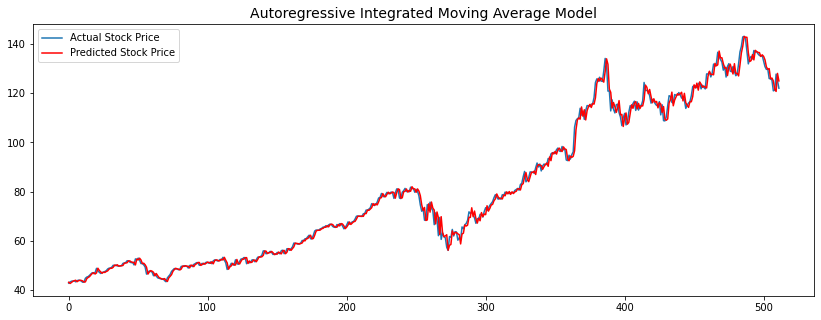

In [8]:
#圖示結果，顯示預測歷史數據的狀況
#up=pd.DataFrame(up_bound)
#low=pd.DataFrame(low_bound)
plt.figure(figsize = (14,5))
plt.title("Autoregressive Integrated Moving Average Model",fontsize=14)
#plt.plot(up, label='up_bound',color='yellow')
#plt.plot(low, label='low_bound',color='yellow')
plt.plot(test, label = 'Actual Stock Price')
plt.plot(predictions, color = 'r', label = 'Predicted Stock Price')
plt.legend()

In [9]:
#計算MSE
MSE = MSE(test, predictions)
print('Mean Squared Error : '+str(round(MSE,4)))

Mean Squared Error : 4.251
